<a href="https://colab.research.google.com/github/dd-open-source/ml-projects/blob/main/transfer_learning/Emergency_Or_Not/Emergency_vehicle_Image_Classification_using_transfer_learning_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is our solution for [Analytics Vidhya Hackathon](https://datahack.analyticsvidhya.com/contest/janatahack-computer-vision-hackathon)

In [1]:
# Comment this if you are not running in colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet_v2
from sklearn.model_selection import train_test_split
from google.colab import files

### Defines reusable constants

In [3]:
# Data files: 
# Google drive: https://drive.google.com/file/d/1jnhIjWUL7B4K4iJ665f7JgWbODmGAMAn/view
# Download the above data files from our google drive 
# to your google drive or local computer and update the below paths accordingly

project_folder = '/content/drive/MyDrive/ML_Projects/Emergency_Or_Not'
data_dir = path.join(project_folder, 'data')
models_path =path.join(project_folder, 'models')
models_dir = path.join(models_path, "base")
train_csv_path = path.join(data_dir, 'train.csv')
test_csv_path = path.join(data_dir, 'test.csv')
label_col = 'emergency_or_not'
image_idx_col = 'image_idx'
image_names_col = 'image_names'
images_dir = path.join(data_dir, "images")
imgy = imgx = 224
images_npy_file = path.join(data_dir, 'images_{}x{}.npy'.format(imgx, imgy))
submission_csv_path = path.join(data_dir, 'submission.csv')

Define common functions

In [12]:
def get_image_id(img_name):
    return int(img_name[:-4])

def get_image(img_name):
    img_path = path.join(images_dir, img_name)
    return Image.open(img_path)

# Shows a randomly selected images from data
def showImages(df, n=1):
    cols = 5
    rows = max(1, n//cols)
    sample = df.sample(n=n).reset_index(drop=True)
    for idx, row in sample.iterrows():
      img = get_image(row[image_names_col])
      plt.subplot(rows, cols, idx+1)
      plt.title(row[label_col])
      plt.imshow(img)
    plt.figure(figsize=(10, 20))
    plt.show()

# Saves images as numpy array for faster training cycles
def save_images_as_numpy_array(images_dir=images_dir, newx=imgx, newy=imgy):
    if path.exists(images_npy_file):
      print("File exists so skipping")
      return
    files = listdir(images_dir)
    images_arr = np.zeros((len(files), newx, newy, 3))
    for fname in files:
        img = get_image(fname)
        img_id = get_image_id(fname)
        images_arr[img_id] = np.array(img.resize((newx, newy))).astype(np.uint8)
    with open(images_npy_file, 'wb') as f:
        np.save(f, images_arr)

# Creates tensorflow dataset for images
def create_image_dataset(df):
    def extract_image(img_id):
        return all_images_tensor[img_id]
    
    ds = tf.data.Dataset.from_tensor_slices(df[image_idx_col].values.astype(np.int32))
    ds = ds.map(extract_image)
    return ds.prefetch(tf.data.AUTOTUNE)

# Creates tensorflow dataset for images and their labels
def create_dataset_with_labels(df):
    img_ds = create_image_dataset(df)
    labels_ds = tf.data.Dataset.from_tensor_slices(df[label_col].values)
    return tf.data.Dataset.zip((img_ds, labels_ds)).batch(32)

Generate npy files of all images after resizing to given (imgx, imgy) dimensions

In [5]:
save_images_as_numpy_array()

File exists so skipping


### Load data

In [6]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
test_df[image_idx_col] = test_df[image_names_col].str[:-4]
train_df[image_idx_col] = train_df[image_names_col].str[:-4]
with open(images_npy_file, 'rb') as f:
    all_images_tensor = tf.constant(np.load(f))

### Prepare datasets for training and validation

In [13]:
train_data, val_data = train_test_split(train_df, test_size=0.2)
train_ds = create_dataset_with_labels(train_data)
val_ds = create_dataset_with_labels(val_data)
test_ds = create_image_dataset(test_df).batch(32)

### Training deep neaural network using Tensorflow

**Transfer learning**: We are using ResNet model for image classification.
1. In 1st phase, we train our model by freezing keeping pre_trained_model (i.e setting trainable=False)
1. In 2nd phase, we train our model by unfreezing keeping pre_trained_model (i.e setting trainable=True) but with very small learning_rate

In [14]:
def create_model(trainable=False):
    pre_trained_model = resnet_v2.ResNet50V2(include_top=False, pooling='max', weights='imagenet', input_shape=(imgy, imgx, 3))
    input = tf.keras.Input(shape=(imgy, imgx, 3))
    output = resnet_v2.preprocess_input(input)
    output = pre_trained_model(output, training=False)
    output = layers.Dropout(0.2)(output)
    output = layers.Dense(1, activation="sigmoid")(output)
    pre_trained_model.trainable=trainable
    model = tf.keras.Model(input, output)
    return model

def compile_and_fit(model, train_ds, val_ds, model_path, learning_rate, epochs=5, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=patience,
                                                     mode='min', min_delta=0.0001, cooldown=0, min_lr=min(0.0001, learning_rate))
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                                                   mode='min', save_weights_only=True,
                                                                   save_best_only=True)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'], 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model.fit(train_ds, epochs=epochs, validation_data=val_ds,
                      callbacks=[early_stopping, model_checkpoint_callback, reduce_lr])


Fast learning phase by freezing the pre-trained-model

In [15]:
model = create_model()
print(model.summary())
model_path = path.join(models_dir, "best")
model.load_weights(tf.train.latest_checkpoint(models_dir))
compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=0.01, epochs=10, patience=3)

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                              

Slow learning phase by unfreezing the pre-trained model.

**Note:** Generally gives slight boost to our accuracy but it is our part to check if this doesn't improve then we need to use best model from first phase.

In [16]:
# Create best model from saved weights
best_model = create_model()
best_model.load_weights(tf.train.latest_checkpoint(models_dir))
model = create_model(trainable=True)
model.set_weights(best_model.get_weights())
compile_and_fit(model, train_ds, val_ds, model_path, learning_rate=1e-5, epochs=10, patience=3)

Epoch 1/10
42/42 [==============================] - 19s 319ms/step - loss: 0.3346 - accuracy: 0.9650 - val_loss: 0.1630 - val_accuracy: 0.9758 - lr: 1.0000e-05
Epoch 2/10
42/42 [==============================] - 10s 242ms/step - loss: 0.1753 - accuracy: 0.9673 - val_loss: 0.2216 - val_accuracy: 0.9758 - lr: 1.0000e-05
Epoch 3/10
42/42 [==============================] - 11s 270ms/step - loss: 0.0992 - accuracy: 0.9863 - val_loss: 0.1398 - val_accuracy: 0.9788 - lr: 1.0000e-05
Epoch 4/10
42/42 [==============================] - 10s 240ms/step - loss: 0.0583 - accuracy: 0.9932 - val_loss: 0.1660 - val_accuracy: 0.9788 - lr: 1.0000e-05
Epoch 5/10
42/42 [==============================] - 10s 237ms/step - loss: 0.0415 - accuracy: 0.9932 - val_loss: 0.1483 - val_accuracy: 0.9758 - lr: 1.0000e-05
Epoch 6/10
42/42 [==============================] - 10s 239ms/step - loss: 0.0493 - accuracy: 0.9962 - val_loss: 0.1848 - val_accuracy: 0.9727 - lr: 1.0000e-05


As you can see in this example val accuracy slightly reduced in second phase so we will use best model from first phase

#### Check results on test dataset

In [17]:
# Create best model from saved weights
# best_model = create_model()
# best_model.load_weights(tf.train.latest_checkpoint(models_dir))
test_predictions = best_model.predict(test_ds)
test_df[label_col] = (test_predictions>0.5).astype(np.uint0)

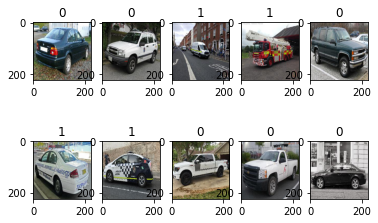

<Figure size 720x1440 with 0 Axes>

In [18]:
showImages(test_df, n=10)

**Create Submission file**

In [19]:
test_df[[image_names_col, label_col]].to_csv(submission_csv_path, index=False)
files.download(submission_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>